# 2D Isostatic gravity inversion - True Model

Este [IPython Notebook](http://ipython.org/videos.html#the-ipython-notebook) utiliza a biblioteca de código aberto [Fatiando a Terra](http://fatiando.org/)

In [1]:
#%matplotlib inline
import numpy as np
from scipy.misc import derivative
import scipy as spy
from scipy import interpolate
import matplotlib
matplotlib.use('TkAgg', force=True)
import matplotlib.pyplot as plt
import math
import cPickle as pickle
import datetime
import string as st

from scipy.misc import imread

from __future__ import division

from fatiando import gravmag, mesher, utils, gridder
from fatiando.mesher import Prism, Polygon
from fatiando.gravmag import prism
from fatiando.utils import ang2vec, si2nt, contaminate
from fatiando.gridder import regular
from fatiando.vis import mpl

from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal
from pytest import raises

plt.rc('font', size=16)

/Users/macelabastos/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
import functions as fc

## Observation coordinates.

In [3]:
# Model`s limits
ymin = 0.0
ymax = 195000.0
zmin = -1000.0
zmax = 37400.0
xmin = -100000.0
xmax = 100000.0

area = [ymin, ymax, zmax, zmin]

In [4]:
ny = 150 # number of observation datas and number of prisms along the profile
# coordinates defining the horizontal boundaries of the
# adjacent columns along the profile
y = np.linspace(ymin, ymax, ny)

In [5]:
# coordinates of the center of the columns forming the
# interpretation model
n = ny - 1
dy = (ymax - ymin)/n
ycmin = ymin + 0.5*dy
ycmax = ymax - 0.5*dy
yc = np.reshape(np.linspace(ycmin, ycmax, n),(n,1))
x = np.zeros_like(yc)
z = np.zeros_like(yc)-150.0

In [6]:
## Edge extension (observation coordinates)
sigma = 2.0
edge = sigma*dy*n

## Model parameters

In [7]:
# Model densities
# Indices and polygons relationship:
# cc = continental crust layer
# oc = ocean crust layer
# w = water layer
# s = sediment layer
# m = mantle layer
dw = np.array([1030.0])
ds = np.array([2550.0])
dcc = np.array([2670.0])
doc = np.array([2840.0])
dm = np.array([3200.0])
#dc = dcc
# coordinate defining the horizontal boundaries of the continent-ocean boundary
COT = 117000.0

# list defining crust density variance
dc = np.zeros_like(yc)
aux = yc <= COT
for i in range(len(yc[aux])):
    dc[i] = dcc
for i in range(len(yc[aux]),n):
    dc[i] = doc
# defining sediments layers density vector
ds = np.reshape(np.repeat(ds,n),(n,1))
    
# S0 => isostatic compensation surface (Airy's model)
# SR = S0+dS0 => reference Moho (Forward modeling)
S0 = np.array([29500.0])
dS0 = np.array([500.0])

## For display

## Water bottom

In [8]:
bath_picks = np.array([[  3.93145161e+02,   1.36801334e+02],
       [  2.75201613e+03,   4.85343517e+02],
       [  6.68346774e+03,   1.00815679e+03],
       [  9.82862903e+03,   1.18242788e+03],
       [  1.94606855e+04,   1.44383452e+03],
       [  3.38104839e+04,   1.79237671e+03],
       [  5.16985887e+04,   1.96664780e+03],
       [  7.07661290e+04,   2.05378334e+03],
       [  8.86542339e+04,   2.14091889e+03],
       [  9.39616935e+04,   2.22805444e+03],
       [  1.14012097e+05,   2.48946107e+03],
       [  1.26003024e+05,   2.40232553e+03],
       [  1.34259073e+05,   2.31518998e+03],
       [  1.37207661e+05,   2.48946107e+03],
       [  1.42711694e+05,   2.66373217e+03],
       [  1.65514113e+05,   2.83800326e+03],
       [  1.94606855e+05,   2.83800326e+03]])

In [9]:
# change the coordinates of the extremum points in order to
# avoid problems for constructing the interpolator
bath_picks[0,0] = ymin
bath_picks[-1,0] = ymax

In [10]:
bathymetry = fc.surface_interpolate_function(bath_picks,yc)

In [11]:
np.savetxt('../data/simple-model-II-bathymetry.txt', bathymetry, fmt='%.18f')

In [12]:
# layer water thickness
tw = np.reshape(bathymetry,(n,1))

# Sediments surfaces

In [13]:
sed_picks = np.array([[    393.14516129,    4129.35204715],
       [   4717.74193548,    3606.53877171],
       [   7666.33064516,    3083.72549628],
       [  10811.49193548,    3083.72549628],
       [  12973.79032258,    3083.72549628],
       [  16118.9516129 ,    4042.21650124],
       [  21819.55645161,    7527.63833747],
       [  30665.32258065,   12494.36445409],
       [  35972.78225806,   15282.70192308],
       [  38921.37096774,   16328.32847395],
       [  42459.67741935,   16502.59956576],
       [  47373.99193548,   14062.8042804 ],
       [  52091.73387097,   13627.12655087],
       [  55630.04032258,   11100.1957196 ],
       [  58971.77419355,   12058.68672457],
       [  61134.07258065,   10751.65353598],
       [  68603.83064516,   12930.04218362],
       [  71355.84677419,   12320.09336228],
       [  73911.29032258,   10751.65353598],
       [  78629.03225806,   11100.1957196 ],
       [  82167.33870968,   12407.22890819],
       [  85312.5       ,   11535.87344913],
       [  88654.23387097,   12407.22890819],
       [  91602.82258065,   10577.38244417],
       [  96320.56451613,   10838.78908189],
       [ 100055.44354839,    9880.29807692],
       [ 103790.32258065,   10838.78908189],
       [ 108508.06451613,    9880.29807692],
       [ 114208.66935484,   10751.65353598],
       [ 116174.39516129,    8834.67152605],
       [ 152736.89516129,    8747.53598015],
       [ 194017.13709677,    8747.53598015]])

In [14]:
# change the coordinates of the extremum points in order to
# avoid problems for constructing the interpolator
sed_picks[0,0] = ymin
sed_picks[-1,0] = ymax

In [15]:
basement = fc.surface_interpolate_function(sed_picks,yc)
for i in range(len(basement)):
    if basement[i] < bathymetry[i]:
        basement[i] = bathymetry[i]

In [16]:
# layer sediments thickness
ts = basement - tw

In [17]:
np.savetxt('../data/simple-model-II-true-basement-surface.txt', basement, fmt='%.18f')

## Moho surface

In [18]:
moho_picks = np.array([[    589.71774194,   28701.57599256],
       [  26733.87096774,   24954.74751861],
       [  38724.7983871 ,   22340.68114144],
       [  54057.45967742,   18332.44602978],
       [  60740.92741935,   17286.81947891],
       [  62706.65322581,   17286.81947891],
       [  68407.25806452,   17896.76830025],
       [  69783.26612903,   17722.49720844],
       [  73125.        ,   16764.00620347],
       [  76663.30645161,   16415.46401985],
       [  80398.18548387,   17548.22611663],
       [  82363.91129032,   17548.22611663],
       [  85509.07258065,   17025.41284119],
       [  90816.53225806,   18158.17493797],
       [  96713.70967742,   17635.36166253],
       [ 106935.48387097,   17286.81947891],
       [ 116567.54032258,   16328.32847395],
       [ 194410.28225806,   16066.92183623]])

In [19]:
# change the coordinates of the extremum points in order to
# avoid problems for constructing the interpolator
moho_picks[0,0] = ymin
moho_picks[-1,0] = ymax

In [20]:
moho = fc.surface_interpolate_function(moho_picks,yc)
for i in range(len(moho)):
    if moho[i] < basement[i]:
        moho[i] = basement[i]

In [21]:
# layer mantle thickness
tm = S0 - moho

# layer crust thickness
toc = moho - tw - ts

In [22]:
np.savetxt('../data/simple-model-II-true-moho-surface.txt', moho, fmt='%.18f')

## Known depths

In [23]:
print '[', np.reshape(yc,(n,))[3], ',' , np.reshape(basement,(n,))[3], '],'
print '[', np.reshape(yc,(n,))[13], ',' , np.reshape(basement,(n,))[13], '],'
print '[', np.reshape(yc,(n,))[40], ',' , np.reshape(basement,(n,))[40], '],'
print '[', np.reshape(yc,(n,))[75], ',' , np.reshape(basement,(n,))[75], '],'
print '[', np.reshape(yc,(n,))[100], ',' , np.reshape(basement,(n,))[100], '],'
#print '[', np.reshape(yc,(n,))[135], ',' , np.reshape(basement,(n,))[135], ']'

[ 4580.53691275 , 3621.74363207 ],
[ 17667.7852349 , 4989.19295015 ],
[ 53003.3557047 , 12976.0791219 ],
[ 98808.7248322 , 10200.2465049 ],
[ 131526.845638 , 8798.08365178 ],


In [24]:
# Basement surface known values
base_known = np.array([[ 4580.53691275 , 3621.74363207 ],
[ 17667.7852349 , 4989.19295015 ],
[ 53003.3557047 , 12976.0791219 ],
[ 98808.7248322 , 10200.2465049 ],
[ 131526.845638 , 8798.08365178 ]])

np.savetxt('../data/simple-model-II-base-known-depths.txt', base_known, fmt='%.18f')

In [25]:
print '[', np.reshape(yc,(n,))[20], ',' , np.reshape(moho,(n,))[20], '],'
print '[', np.reshape(yc,(n,))[47], ',' , np.reshape(moho,(n,))[47], '],'
print '[', np.reshape(yc,(n,))[90], ',' , np.reshape(moho,(n,))[90], '],'
#print '[', np.reshape(yc,(n,))[105], ',' , np.reshape(S,(n,))[105], ']'

[ 26828.8590604 , 24934.0397643 ],
[ 62164.4295302 , 17286.8194789 ],
[ 118439.597315 , 16322.0891169 ],


In [26]:
# Moho surface known values
moho_known = np.array([[ 26828.8590604 , 24934.0397643 ],
[ 62164.4295302 , 17286.8194789 ],
[ 118439.597315 , 16322.0891169 ]])

np.savetxt('../data/simple-model-II-moho-known-depths.txt', moho_known, fmt='%.18f')

## Synthetic data

In [27]:
# parameters vector
psyn = []
psyn = np.vstack((ts, tm, dS0))

In [28]:
# prisms calculation by Fatiando a Terra
prism_w_syn = fc.prism_w_function(xmax,xmin,dy,edge,dw,dcc,tw,yc)
prism_s_syn = fc.prism_s_function(xmax,xmin,dy,edge,ds,dcc,tw,psyn,yc)
prism_c_syn = fc.prism_c_function(xmax,xmin,dy,edge,S0,dcc,dc,tw,psyn,yc)
prism_m_syn = fc.prism_m_function(xmax,xmin,dy,edge,S0,dcc,dm,psyn,yc)

In [29]:
# z component of gravity calculation by Fatiando a Terra
gzw_syn = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_w_syn)
gzs_syn = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_s_syn[0])
gzc_syn = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_c_syn)
gzm_syn = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_m_syn)

#Observed data calculation:
gsyn = gzw_syn + gzs_syn + gzc_syn + gzm_syn
#gsyn = fc.g_function(x,yc,z,gzw_syn,prism_s_syn,prism_c_syn,prism_m_syn)

In [30]:
np.savetxt('../data/simple-model-II-synthetic-gravity-data.txt', gsyn, fmt='%.18f')

## Model plot

In [31]:
polygons_water = []
for (yi, twi) in zip(yc, bathymetry):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_water.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [0.0, 0.0, twi, twi]]).T,
                                               props={'density': dw - dcc}))
polygons_sediments = []
for (yi, twi, si, dsi) in zip(yc, np.reshape(bathymetry,(n,)), np.reshape(basement,(n,)), ds):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_sediments.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [twi, twi, si, si]]).T,
                                                    props={'density': ds - dcc}))

polygons_crust = []
for (yi, si, Si, dci) in zip(yc, np.reshape(basement,(n,)), np.reshape(moho,(n,)), dc):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_crust.append(Polygon(np.array([[y1, y2, y2, y1], 
                                            [si, si, Si, Si]]).T,
                                                props={'density': dci - dcc})) 

polygons_mantle = []
for (yi, Si) in zip(yc, np.reshape(moho,(n,))):
    y1 = yi - 0.5*dy
    y2 = yi + 0.5*dy

    polygons_mantle.append(Polygon(np.array([[y1, y2, y2, y1], 
                                                [Si, Si, S0+dS0, S0+dS0]]).T,
                                                    props={'density': dm - dcc}))

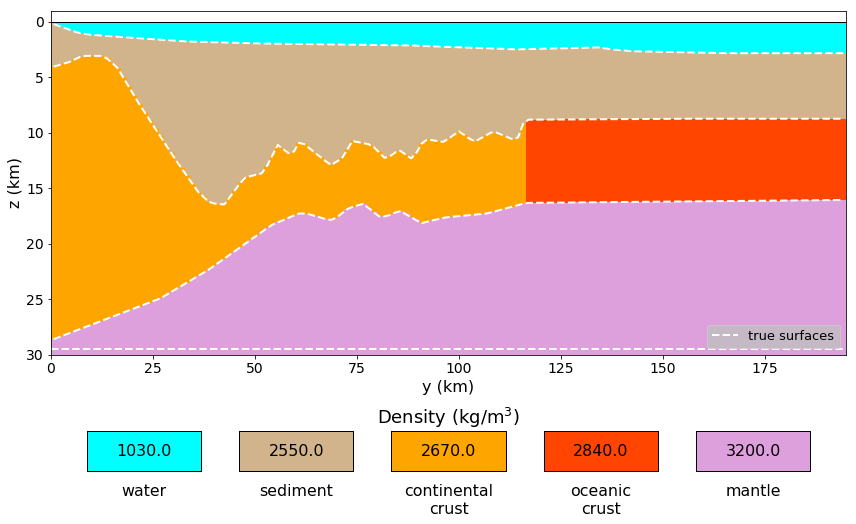

In [32]:
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(12,7))

import matplotlib.gridspec as gridspec
heights = [8, 1]
gs = gridspec.GridSpec(2, 1, height_ratios=heights)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.axhline(y=0.0, xmin=ymin, xmax=ymax, color='k', linestyle='-', linewidth=1)
aux = yc <= COT
for (pwi) in (polygons_water):
    tmpx = [x for x in pwi.x]
    tmpx.append(pwi.x[0])
    tmpy = [y for y in pwi.y]
    tmpy.append(pwi.y[0])
    ax1.plot(tmpx, tmpy, linestyle='None')
    ax1.fill(tmpx, tmpy, color='aqua')
for (psi) in (polygons_sediments):
    tmpx = [x for x in psi.x]
    tmpx.append(psi.x[0])
    tmpy = [y for y in psi.y]
    tmpy.append(psi.y[0])
    ax1.plot(tmpx, tmpy, linestyle='None')
    ax1.fill(tmpx, tmpy, color='tan')
for (pci) in (polygons_crust[:len(yc[aux])]):
    tmpx = [x for x in pci.x]
    tmpx.append(pci.x[0])
    tmpy = [y for y in pci.y]
    tmpy.append(pci.y[0])
    ax1.plot(tmpx, tmpy, linestyle='None')
    ax1.fill(tmpx, tmpy, color='orange')
for (pcoi) in (polygons_crust[len(yc[aux]):n]):
    tmpx = [x for x in pcoi.x]
    tmpx.append(pcoi.x[0])
    tmpy = [y for y in pcoi.y]
    tmpy.append(pcoi.y[0])
    ax1.plot(tmpx, tmpy, linestyle='None')
    ax1.fill(tmpx, tmpy, color='orangered')
for (pmi) in (polygons_mantle):
    tmpx = [x for x in pmi.x]
    tmpx.append(pmi.x[0])
    tmpy = [y for y in pmi.y]
    tmpy.append(pmi.y[0])
    ax1.plot(tmpx, tmpy, linestyle='None')
    ax1.fill(tmpx, tmpy, color='plum')

ax1.axhline(y=S0, xmin=ymin, xmax=ymax, color='w', linestyle='--', linewidth=2)
#ax1.axvline(x=COT, ymin=ybottom, ymax=ytop, linestyle=':', color='w', linewidth=3, label='COT')
ax1.plot(yc, tw, '--w', linewidth=2)
ax1.plot(yc, basement, '--w', linewidth=2, label='true surfaces')
ax1.plot(yc, moho, '--w', linewidth=2)
ax1.set_ylim((S0+dS0), zmin)
ax1.set_xlim(ymin, ymax)
ax1.set_xlabel('y (km)', fontsize=16)
ax1.set_ylabel('z (km)', fontsize=16)
ax1.set_xticklabels(['%g'% (0.001*l) for l in ax1.get_xticks()], fontsize=14)
ax1.set_yticklabels(['%g'% (0.001*l) for l in ax1.get_yticks()], fontsize=14)
ax1.legend(loc='lower right', fontsize=13, facecolor='silver')    

X, Y = fig.get_dpi()*fig.get_size_inches()
plt.title('Density (kg/m$^{3}$)', fontsize=18)
ax2.axis('off')

layers_list1 = ['water', 'sediment', 'continental', 'oceanic', 'mantle']
layers_list2 = ['', '', 'crust', 'crust', '']
colors_list = ['aqua', 'tan', 'orange', 'orangered', 'plum']
density_list = ['1030.0', '2550.0', '2670.0', '2840.0', '3200.0']
ncols = len(colors_list)
nrows = 1
h = Y / nrows
w = X / (ncols + 1)

i=ncols-1
for color, density, layers1, layers2 in zip(colors_list, density_list, layers_list1, layers_list2):
    col = i // nrows
    row = i % nrows
    x = X - (col*w) - w
    
    yi_line = Y
    yf_line = Y - Y*0.15
    yi_text1 = Y - Y*0.2
    yi_text2 = Y - Y*0.27
    yi_text3 = Y - Y*0.075
    
    i-=1
    poly = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yi_line, yi_line, yf_line, yf_line]]).T)
    tmpx = [x for x in poly.x]
    tmpx.append(poly.x[0])
    tmpy = [y for y in poly.y]
    tmpy.append(poly.y[0])
    ax2.plot(tmpx, tmpy, linestyle='-', color='k', linewidth=1)
    ax2.fill(tmpx, tmpy, color=color)
    ax2.text(x+w*0.375, yi_text1, layers1, fontsize=(w*0.11), horizontalalignment='center', verticalalignment='top')
    ax2.text(x+w*0.375, yi_text2, layers2, fontsize=(w*0.11), horizontalalignment='center', verticalalignment='top')
    ax2.text(x+w*0.375, yi_text3, density, fontsize=(w*0.11), horizontalalignment='center', verticalalignment='center')

plt.tight_layout()    
    
#mpl.savefig('../data/fig/simple-model-II-true-model.png', dpi='figure', bbox_inches='tight')
plt.show()      

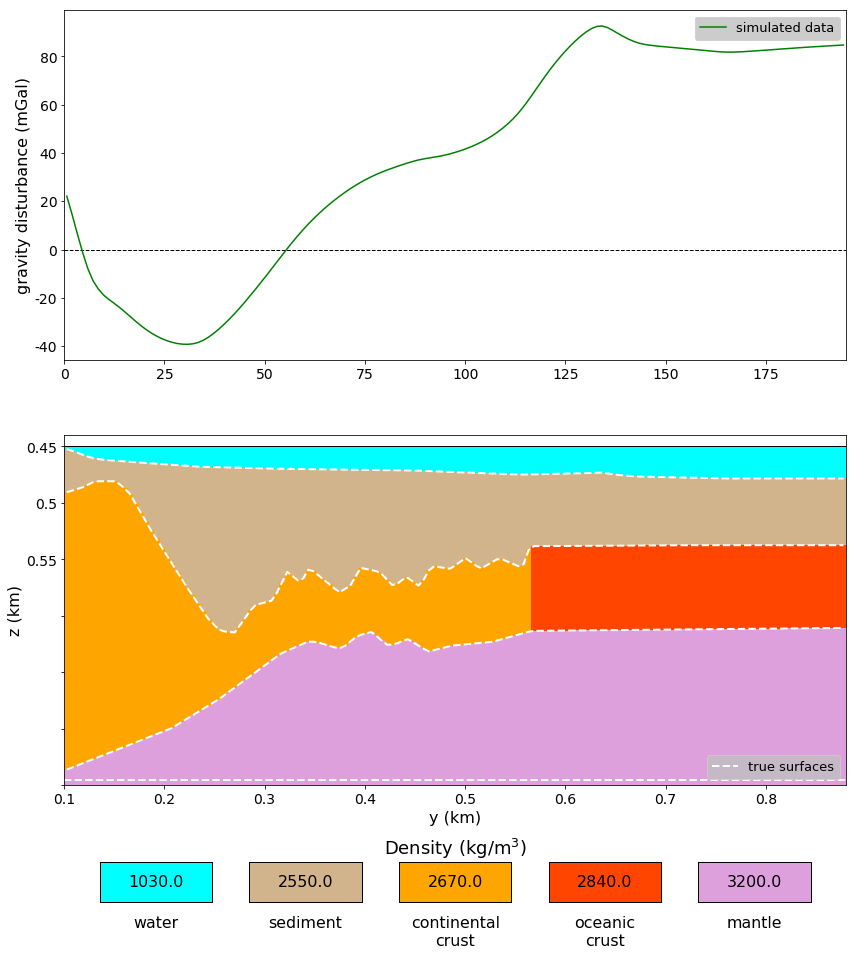

In [33]:
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(12,13))

import matplotlib.gridspec as gridspec
heights = [8, 8, 1]
gs = gridspec.GridSpec(3, 1, height_ratios=heights)
ax3 = plt.subplot(gs[0])
ax4 = plt.subplot(gs[1])
ax5 = plt.subplot(gs[2])

ax3.axhline(y=0.0, xmin=ymin, xmax=ymax, color='k', linestyle='--', linewidth=1)
ax3.plot(0.001*yc, gsyn, '-g', label='simulated data')
ax3.set_xlim(0.001*ymin, 0.001*ymax)
ax3.set_ylabel('gravity disturbance (mGal)', fontsize=16)
ax3.set_xticklabels(['%g'% (l) for l in ax3.get_xticks()], fontsize=14)
ax3.set_yticklabels(['%g'% (l) for l in ax3.get_yticks()], fontsize=14)
ax3.legend(loc='best', fontsize=13, facecolor='silver')

ax4.axhline(y=0.0, xmin=ymin, xmax=ymax, color='k', linestyle='-', linewidth=1)
aux = yc <= COT
for (pwi) in (polygons_water):
    tmpx = [x for x in pwi.x]
    tmpx.append(pwi.x[0])
    tmpy = [y for y in pwi.y]
    tmpy.append(pwi.y[0])
    ax4.plot(tmpx, tmpy, linestyle='None')
    ax4.fill(tmpx, tmpy, color='aqua')
for (psi) in (polygons_sediments):
    tmpx = [x for x in psi.x]
    tmpx.append(psi.x[0])
    tmpy = [y for y in psi.y]
    tmpy.append(psi.y[0])
    ax4.plot(tmpx, tmpy, linestyle='None')
    ax4.fill(tmpx, tmpy, color='tan')
for (pci) in (polygons_crust[:len(yc[aux])]):
    tmpx = [x for x in pci.x]
    tmpx.append(pci.x[0])
    tmpy = [y for y in pci.y]
    tmpy.append(pci.y[0])
    ax4.plot(tmpx, tmpy, linestyle='None')
    ax4.fill(tmpx, tmpy, color='orange')
for (pcoi) in (polygons_crust[len(yc[aux]):n]):
    tmpx = [x for x in pcoi.x]
    tmpx.append(pcoi.x[0])
    tmpy = [y for y in pcoi.y]
    tmpy.append(pcoi.y[0])
    ax4.plot(tmpx, tmpy, linestyle='None')
    ax4.fill(tmpx, tmpy, color='orangered')
for (pmi) in (polygons_mantle):
    tmpx = [x for x in pmi.x]
    tmpx.append(pmi.x[0])
    tmpy = [y for y in pmi.y]
    tmpy.append(pmi.y[0])
    ax4.plot(tmpx, tmpy, linestyle='None')
    ax4.fill(tmpx, tmpy, color='plum')

ax4.axhline(y=S0, xmin=ymin, xmax=ymax, color='w', linestyle='--', linewidth=2)
#ax4.axvline(x=COT, ymin=ybottom, ymax=ytop, linestyle=':', color='w', linewidth=3, label='COT')
ax4.plot(yc, tw, '--w', linewidth=2)
ax4.plot(yc, basement, '--w', linewidth=2, label='true surfaces')
ax4.plot(yc, moho, '--w', linewidth=2)
ax4.set_ylim((S0+dS0), zmin)
ax4.set_xlim(ymin, ymax)
ax4.set_xlabel('y (km)', fontsize=16)
ax4.set_ylabel('z (km)', fontsize=16)
ax4.set_xticklabels(['%g'% (0.001*l) for l in ax2.get_xticks()], fontsize=14)
ax4.set_yticklabels(['%g'% (0.001*l) for l in ax2.get_yticks()], fontsize=14)
ax4.legend(loc='lower right', fontsize=13, facecolor='silver')    

X, Y = fig.get_dpi()*fig.get_size_inches()
plt.title('Density (kg/m$^{3}$)', fontsize=18)
ax5.axis('off')

layers_list1 = ['water', 'sediment', 'continental', 'oceanic', 'mantle']
layers_list2 = ['', '', 'crust', 'crust', '']
colors_list = ['aqua', 'tan', 'orange', 'orangered', 'plum']
density_list = ['1030.0', '2550.0', '2670.0', '2840.0', '3200.0']
ncols = len(colors_list)
nrows = 1
h = Y / nrows
w = X / (ncols + 1)

i=ncols-1
for color, density, layers1, layers2 in zip(colors_list, density_list, layers_list1, layers_list2):
    col = i // nrows
    row = i % nrows
    x = X - (col*w) - w
    
    yi_line = Y
    yf_line = Y - Y*0.15
    yi_text1 = Y - Y*0.2
    yi_text2 = Y - Y*0.27
    yi_text3 = Y - Y*0.075
    
    i-=1
    poly = Polygon(np.array([[x, x+w*0.75, x+w*0.75, x], [yi_line, yi_line, yf_line, yf_line]]).T)
    tmpx = [x for x in poly.x]
    tmpx.append(poly.x[0])
    tmpy = [y for y in poly.y]
    tmpy.append(poly.y[0])
    ax5.plot(tmpx, tmpy, linestyle='-', color='k', linewidth=1)
    ax5.fill(tmpx, tmpy, color=color)
    ax5.text(x+w*0.375, yi_text1, layers1, fontsize=(w*0.11), horizontalalignment='center', verticalalignment='top')
    ax5.text(x+w*0.375, yi_text2, layers2, fontsize=(w*0.11), horizontalalignment='center', verticalalignment='top')
    ax5.text(x+w*0.375, yi_text3, density, fontsize=(w*0.11), horizontalalignment='center', verticalalignment='center')

plt.tight_layout()    
    
#mpl.savefig('../data/fig/simple-model-II-true-model-grafics.png', dpi='figure', bbox_inches='tight')
plt.show()      